In [1]:
## Installs for Colab:
#
!pip install swig
!pip install pocketsphinx
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373074 sha256=ef088ac527d04ee2cd7e59fb4c60f24197fb78cc67669d3872200ff59bd3a9de
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
## Imports:

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
#   To save the ouput of the renders to an mp4 file:
# from gym import wrappers
# from gym.wrappers import Monitor

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Parameters used in the experiment:

- TODO 1
- TODO 2
- etc


In [ ]:
## Actor-Critic neural network implementation

class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        self.actor = nn.Linear(fc2_dims, n_actions)
        self.critic = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

        # self.criterion = nn.MSELoss()

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.actor(x)      # Actor returns the action (policy distribution)
        v = self.critic(x)      # Critic returns the action-value

        return (pi, v)



In [ ]:
## Agent implementation

class Agent():
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, gamma=0.99):
        self.gamma = gamma
        self.lr = lr
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.actor_critic = ActorCriticNetwork(lr, input_dims, n_actions,
                                               fc1_dims, fc2_dims)
        self.log_prob = None

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor_critic.device)
        probabilities, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(probabilities, dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()

    def learn(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()

        state = T.tensor([state], dtype=T.float).to(self.actor_critic.device)
        state_ = T.tensor([state_], dtype=T.float).to(self.actor_critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2


        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

        return actor_loss, critic_loss, delta



In [ ]:
## Experiment results plotting functions

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.show()
    # plt.savefig(figure_file)

def plot_mse(x, loss):
    plt.plot(x, loss, label='Loss')
    #plt.plot(x, critic_loss, label='Critic Loss')
    plt.xlabel('Episode')
    plt.ylabel('MSE Loss')
    plt.title('Mean Square Error')
    plt.legend()
    plt.show()

def plot_win_loss():
    pass

In [ ]:
## Main

env = gym.make('LunarLander-v2')    # running in Discrete mode

agent = Agent(gamma=0.99, lr=5e-6, input_dims=[8], n_actions=4, fc1_dims=2048, fc2_dims=1536)

n_games = 1000
scores = []
actor_losses = []
critic_losses = []
weights = []
delta_array = []

wins = 0
for i in range(n_games):
    done = False
    observation = env.reset()[0]    # return type is tuple, 1st element is the 8-dimensional vector of state values

    score = 0
    episode_actor_loss = 0
    episode_critic_loss = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        score += reward
        actor_loss, critic_loss, delta = agent.learn(observation, reward, observation_, done)
        episode_actor_loss += actor_loss.item()
        episode_critic_loss += critic_loss.item()
        observation = observation_



    w = agent.actor_critic.actor.weight.data.cpu().numpy().flatten()
    current_weight = w[:10]
    scores.append(score)
    actor_losses.append(episode_actor_loss)
    critic_losses.append(episode_critic_loss)
    weights.append(current_weight)
    weights_array = np.vstack(weights)
    d = delta.detach().cpu().numpy()
    delta_array.append(d)
    delta_array_pretty = np.ravel(delta_array)

    if score >= 200:
        wins += 1
    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score %.1f' % score, 'average score %.1f' % avg_score)
    #print(delta_array_pretty)



episode  0 score -88.1 average score -88.1
episode  1 score -287.1 average score -187.6
episode  2 score -418.3 average score -264.5
episode  3 score -360.9 average score -288.6
episode  4 score -110.7 average score -253.0
episode  5 score -277.0 average score -257.0
episode  6 score -305.3 average score -263.9
episode  7 score -246.8 average score -261.8
episode  8 score -79.5 average score -241.5
episode  9 score -343.7 average score -251.7
episode  10 score -251.7 average score -251.7
episode  11 score -42.5 average score -234.3
episode  12 score -155.5 average score -228.2
episode  13 score -350.4 average score -236.9
episode  14 score -215.2 average score -235.5
episode  15 score -78.4 average score -225.7
episode  16 score -179.1 average score -222.9
episode  17 score -530.9 average score -240.1
episode  18 score -179.7 average score -236.9
episode  19 score -45.9 average score -227.3
episode  20 score -2.3 average score -216.6
episode  21 score -186.2 average score -215.2
episod

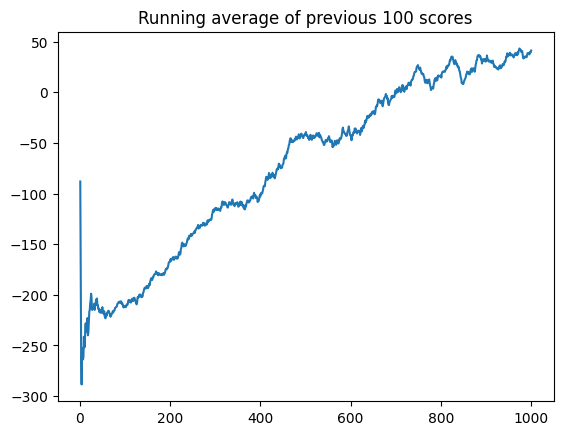

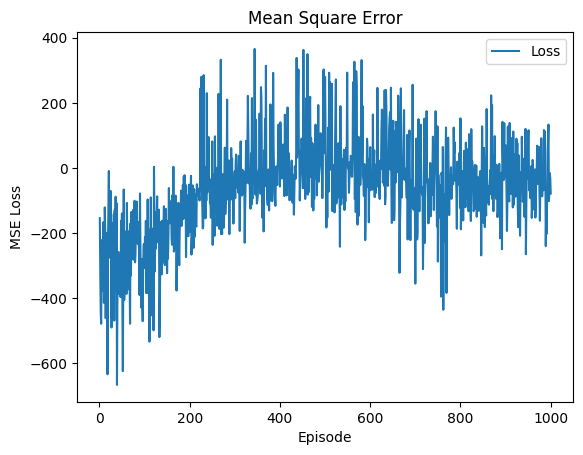

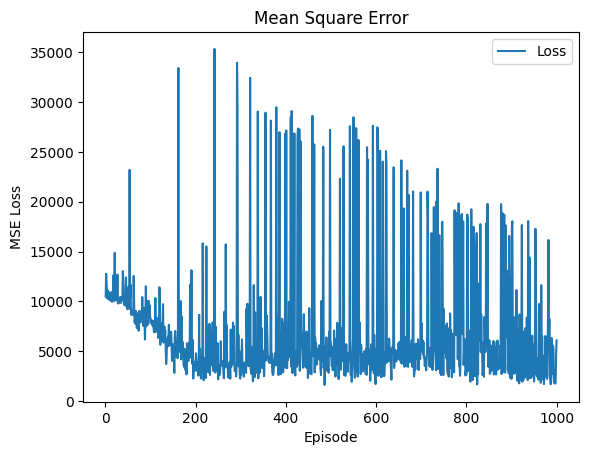

In [ ]:
## Post-run visualizations
fname = 'ACTOR_CRITIC_' + 'lunar_lander_' + str(agent.fc1_dims) + \
        '_fc1_dims_' + str(agent.fc2_dims) + '_fc2_dims_lr' + str(agent.lr) +\
        '_' + str(n_games) + 'games'

figure_file = fname + '.png'

x = [i+1 for i in range(n_games)]

plot_learning_curve(x, scores, figure_file)
plot_mse(x, actor_losses)
plot_mse(x, critic_losses)


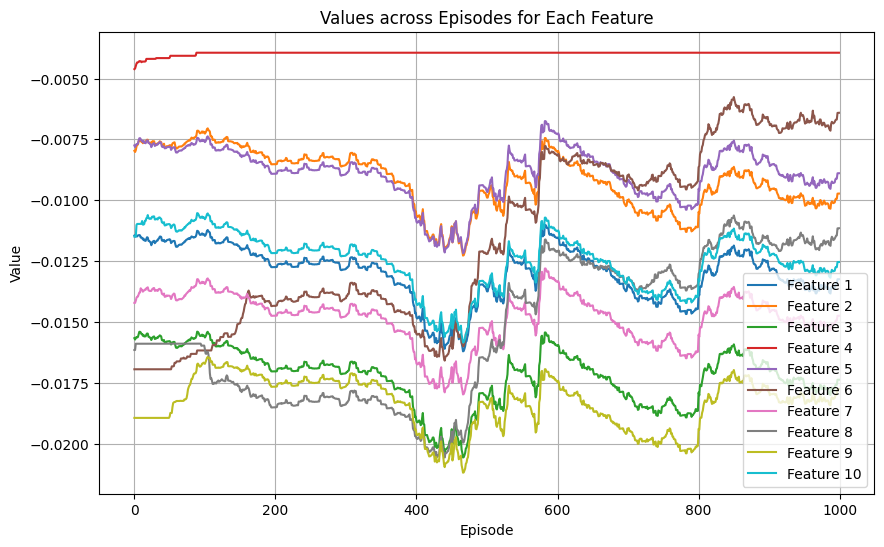

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# Plot each row as a separate line
for i in range(weights_array.shape[1]):  # Iterate through columns (features)
    plt.plot(weights_array[:, i], label=f'Feature {i+1}')

# Set labels and title
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Values across Episodes for Each Feature')
plt.legend()
plt.grid(True)
plt.show()

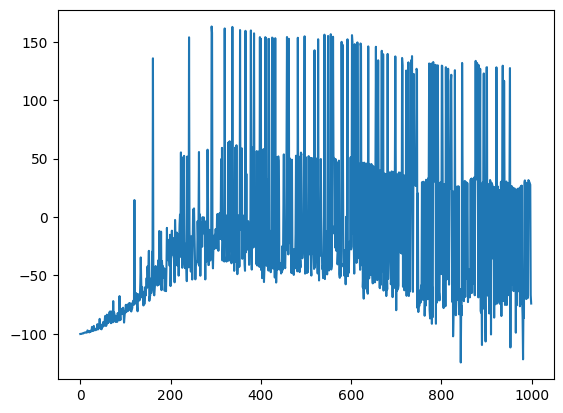

In [ ]:
plt.plot(delta_array_pretty)